## Experiments on FC
Visualize relationships between FC values, calculate correlations intra/inter
And relate FC-SC values.

See if some relationships are the same

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from functools import reduce
import sys
# ignore warnings for easier plotting
import warnings

from scipy import stats
from statannotations.Annotator import Annotator
import itertools 

warnings.filterwarnings("ignore")

sys.path.append('../')

from PAPER_FIGURES_TABLES.load_data import load_data

In [2]:
sns.set(style='darkgrid', context='paper', palette='Set1', font="serif")

In [3]:
# Hue colors order and names
# auxiliar dict to put correct order in the figure
map_hue_color = {
    "EDSS_group": ["EDSS<3", "EDSS>=3"],
    "SDMT_group": ["SDMT>=40", "SDMT<40"],
    "G_norm": ['G_z<=0', 'G_z>0'], 
    "Corr_norm": ['C_z<=0', 'C_z>0'],
    "disease": ["HC", "MS"],
    "GROUP": ["HC", "CIS", "RRMS", "SPMS", "PPMS"],
    "CENTER": ["CLINIC", "MAINZ", "MILAN", "NAPLES", "OSLO", "LONDON", "AMSTERDAM"]
    # "GROUP": ["HC", "RRMS", "SPMS", "PPMS"]
}

# get the progressives together.
mapping_prog = {
    "HC": "HC",
    "CIS": "CIS", 
    "RRMS": "RRMS", 
    "SPMS": "PMS", 
    "PPMS": "PMS"
}

df_merged = load_data()
print(df_merged.columns.values)

['SubjID' 'DOB' 'SEX' 'GROUP' 'ONSET_DATE' 'MR_DATE' 'TREATMENT_AT_MRI'
 'TREATMENT' 'EDSS' 'YED' 'SDMT' 'RAO_SRTS' 'RAO_SRTR' 'RAO_SRTD'
 'RAO_10_36_SRTR' 'RAO_10_36_SRTD' 'RAO_WLG' 'RAO_PASAT' 'CENTER'
 'FMRI_TR' 'FMRI_NSCANS' 'FMRI_SCANTIME' 'AGE' 'DD' 'BICAMS_CVLT2'
 'BICAMS_BVMTR' 'NPS_x' '9HPT_dH' '9HPT_ndH' 'T25FW' 'motor_x'
 'Datecognitiveevaluation' 'TypeRAO' 'RAO_PASAT2sec'
 'RAO_WLGperseveration' 'RAO_WLGintrusion' 'Right9HPT' 'Left9HPT'
 'MFIS_TOTAL' 'MFIS_PHYS_FUNCT' 'MFIS_COGN_FUNCT' 'MFIS_SOCIAL_FUNCT'
 'BDI_II' '9HPT_average' 'notes_NPS' '9HPT_dH_' 'DWI_PROT' 'SCANNER'
 'SRTL_sum' 'PASAT2' 'WRDLG' 'QC' 'CENTER2' 'GM' 'GMF' 'WM' 'WMF' 'CSF'
 'CSFF' 'LV' 'LVF' 'BPF' 'RDwm_mean' 'RDwm_std' 'RDlwm_mean' 'RDlwm_std'
 'RDl_mean' 'RDl_std' 'RD_gm' 'RD_gmwm' 'Meta_x' 'Meta_noreg'
 'Unnamed: 21' 'Unnamed: 22' 'Unnamed: 23' 'FAwm_mean' 'FAwm_std'
 'FAlwm_mean' 'FAlwm_std' 'FAl_mean' 'FAl_std' 'FA_gm' 'FA_gmwm'
 'CC_Sag_area' 'CC_Posterior' 'CC_Mid_Posterior' 'CC_Central'
 'CC_Mid

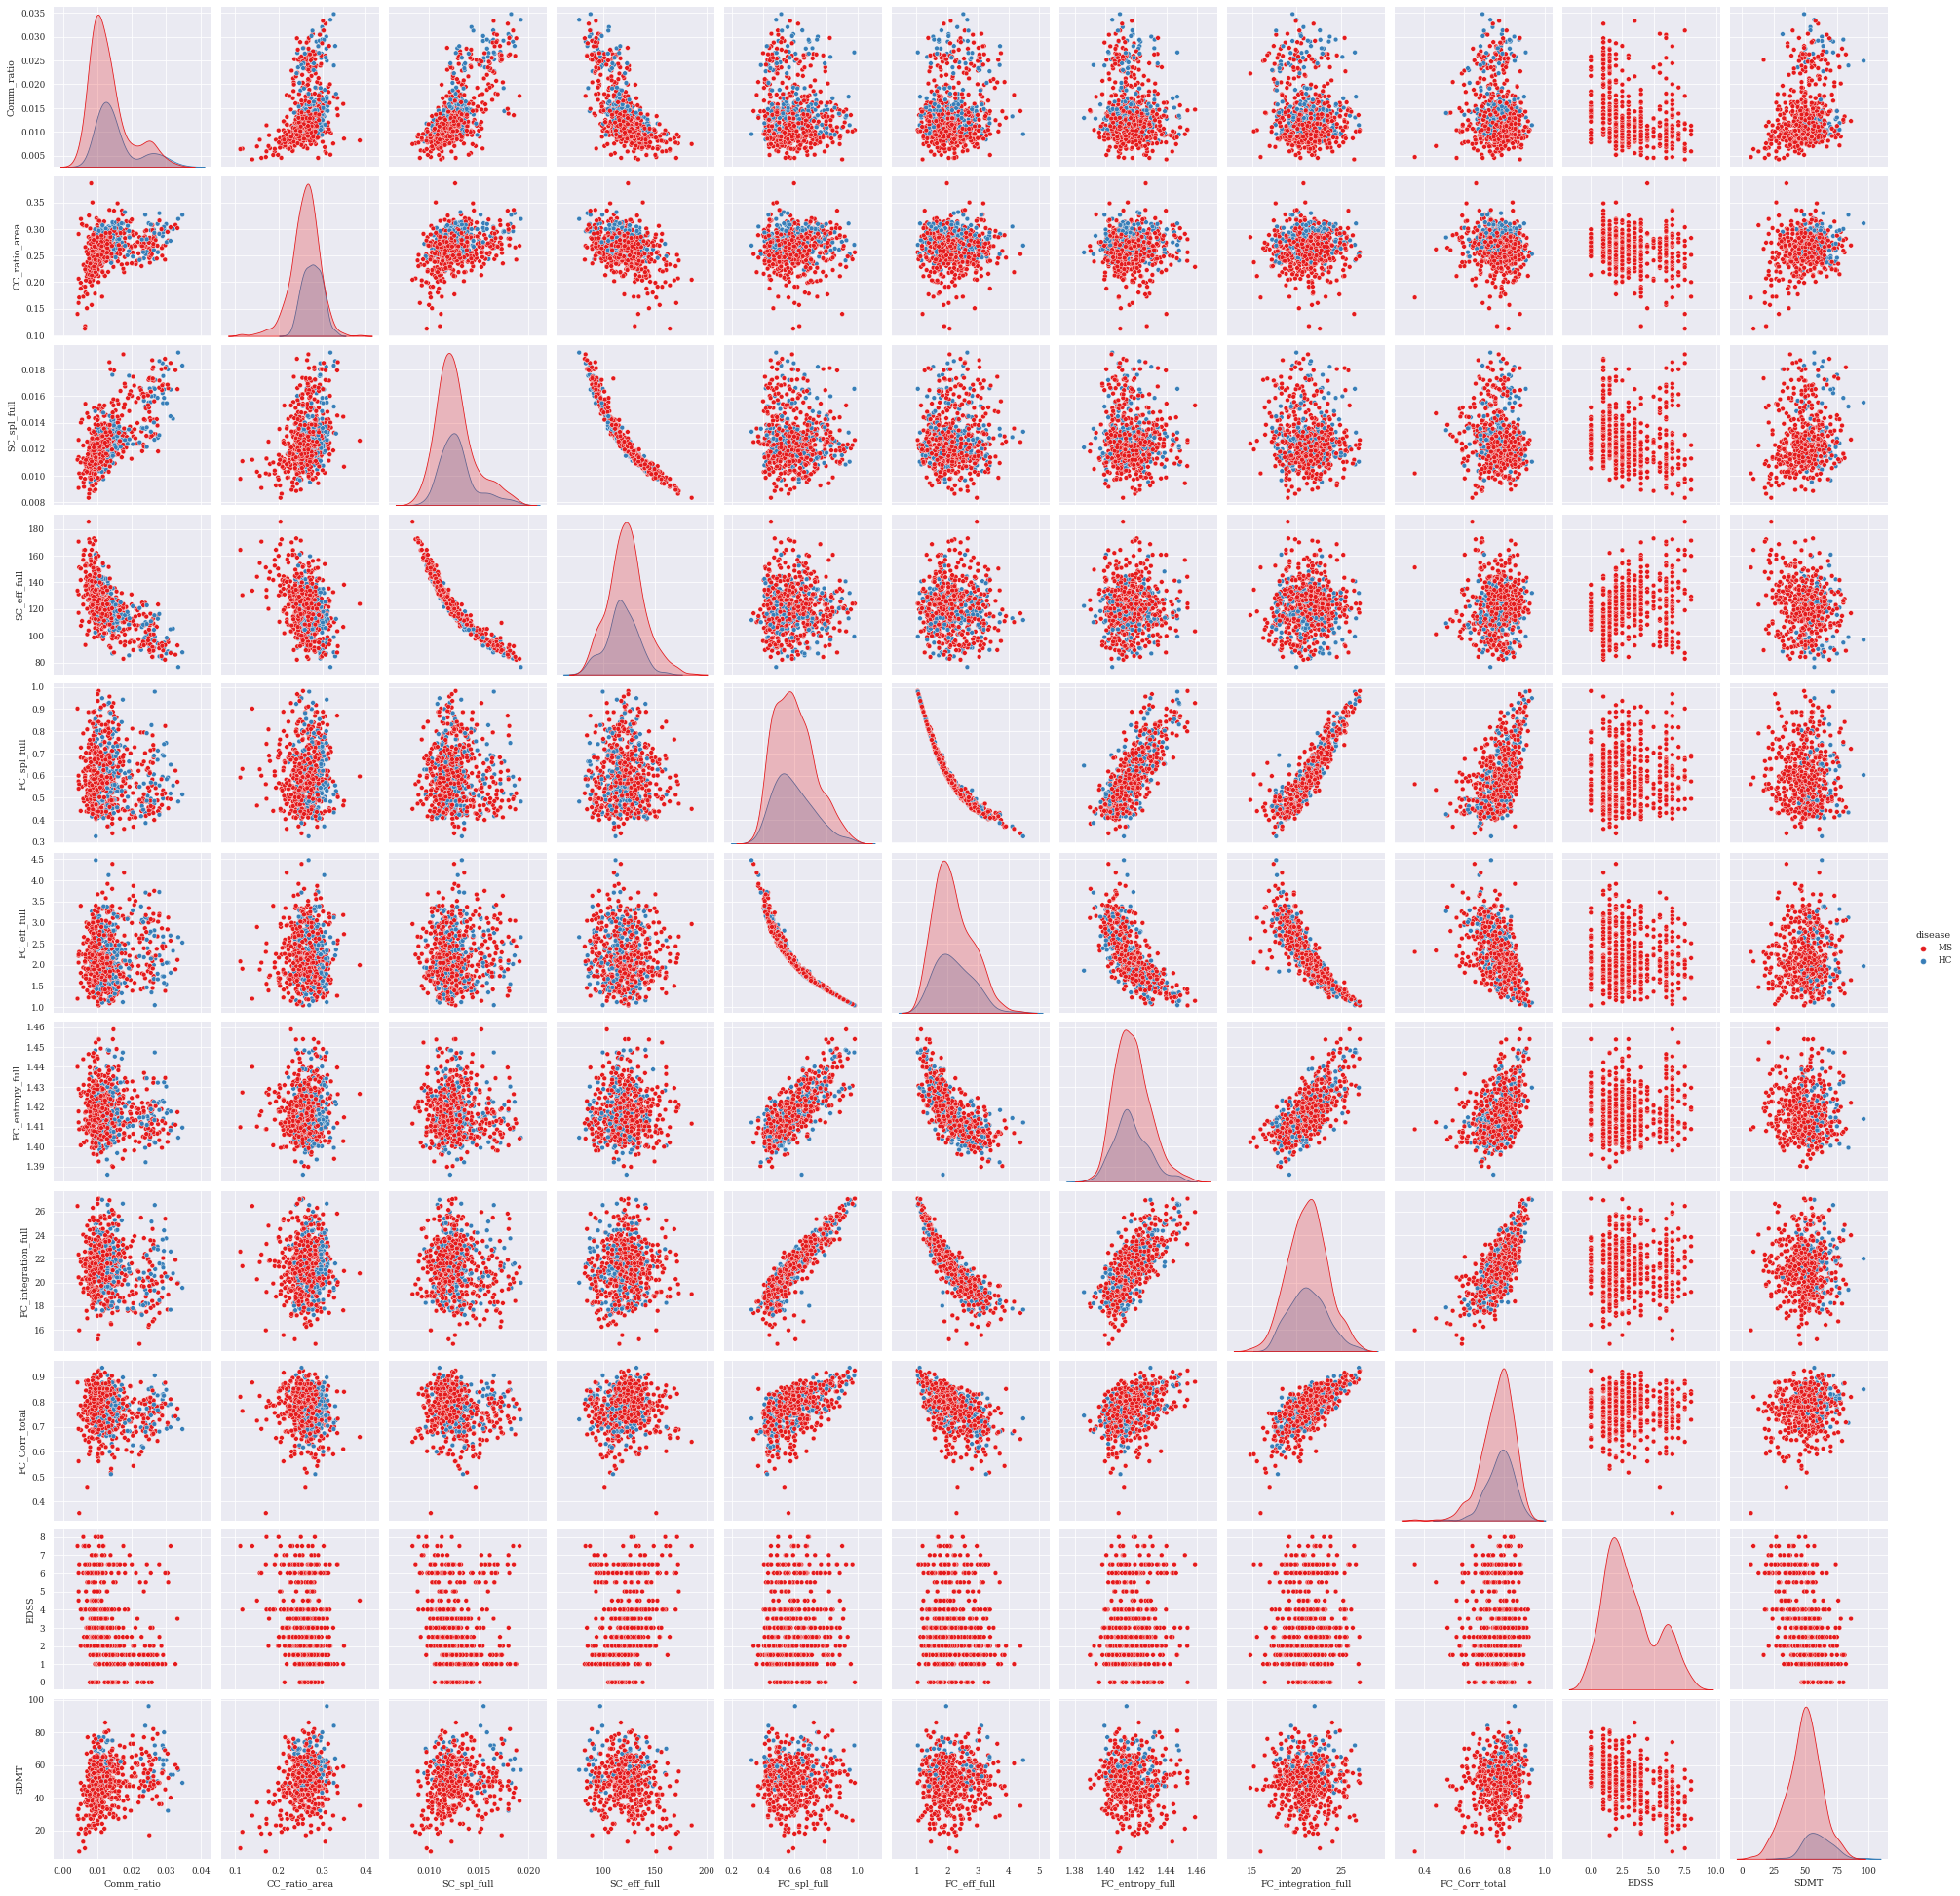

In [9]:
sns.pairplot(df_merged, vars = ['Comm_ratio', 'CC_ratio_area', 'SC_spl_full', 'SC_eff_full', 'FC_spl_full', 'FC_eff_full',
 'FC_entropy_full', 'FC_integration_full', 'FC_Corr_total', 'EDSS', 'SDMT'], hue='disease')

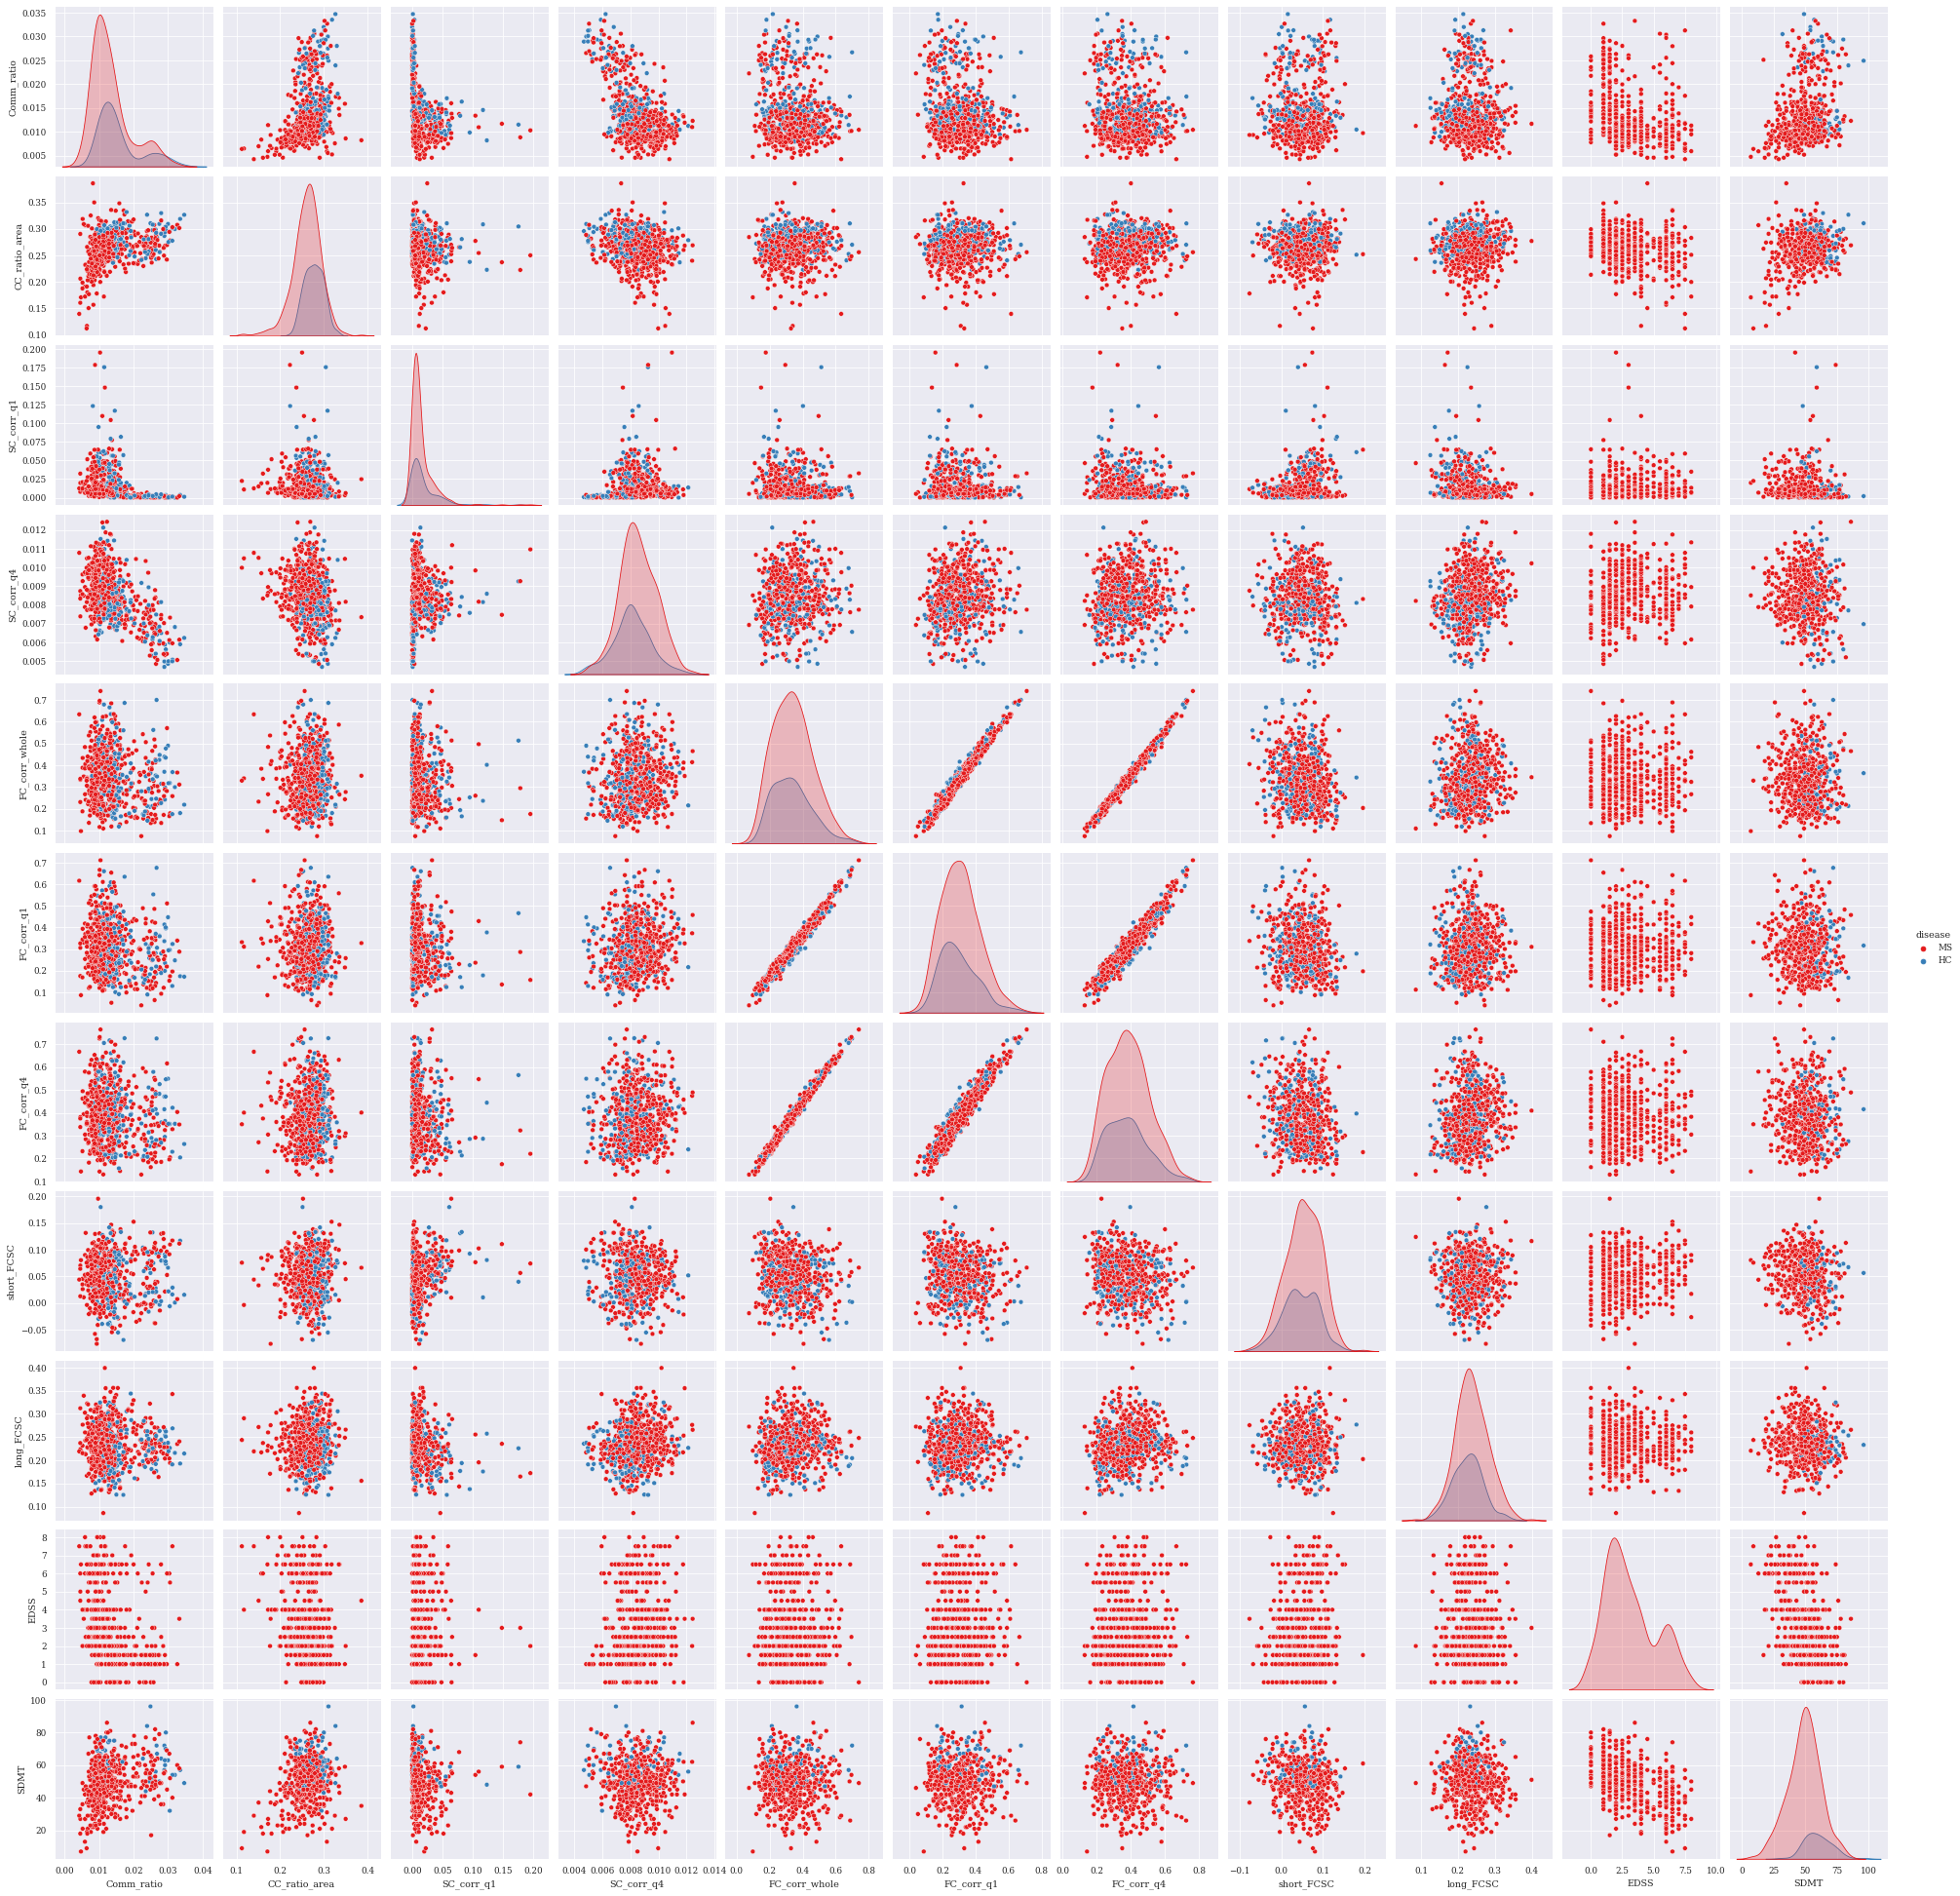

In [10]:
sns.pairplot(df_merged, vars = ['Comm_ratio', 'CC_ratio_area', 'SC_corr_q1', 'SC_corr_q4',
 'FC_corr_whole', 'FC_corr_q1', 'FC_corr_q4', 'short_FCSC', 'long_FCSC','EDSS', 'SDMT'], hue='disease')

In [5]:
# Decide on the values
print(len(df_merged))
x1 = "Comm_ratio"
x2 = "CC_ratio_area"

y1 = "FC_spl_full"
y2 = "FC_eff_full"


tidy = (
    df_merged[[x1, x2, y1, y2]].stack() # pull the columns into row variables   
      .to_frame() # convert the resulting Series to a DataFrame
      .reset_index() # pull the resulting MultiIndex into the columns
      .rename(columns={0: 'val'}) # rename the unnamed column
)

print(tidy.head())


697
   level_0        level_1       val
0        0     Comm_ratio  0.010277
1        0  CC_ratio_area  0.221946
2        0    FC_spl_full  0.681300
3        0    FC_eff_full  1.692807
4        1     Comm_ratio  0.010640


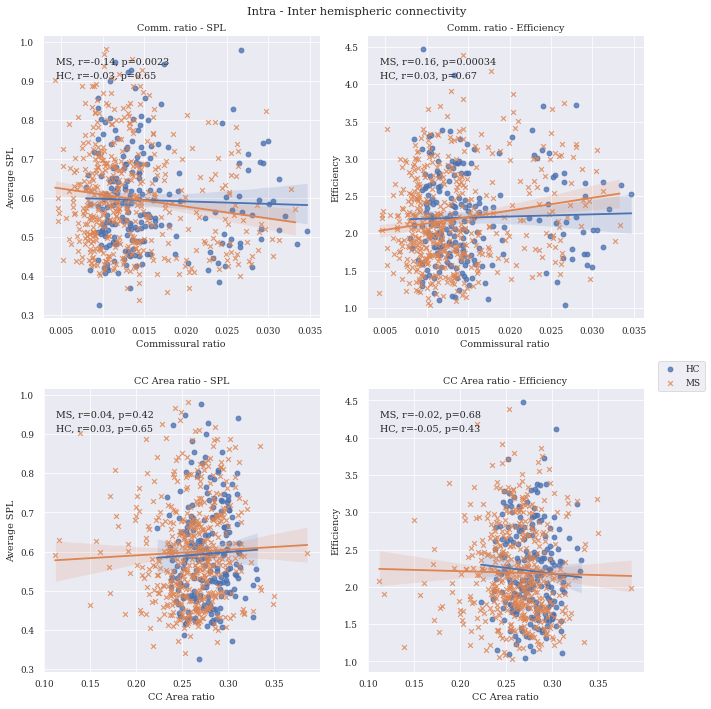

In [6]:
def annotate(col1, col2, data, multihue=False, **kwargs):
    if len(data[col1]) >= 2 or len(data[col2]) >= 2:
        r, p = stats.pearsonr(data[col1], data[col2])
        ax = plt.gca()

        # hardcoded, udpate if working with other labels
        x_pos = 0.05
        if multihue:
            label = kwargs["label"]
            dict_of_labels = {"CIS": 0, "RRMS": 1, "PMS": 2, 'MS':0, 'HC':1}
            y_pos = 0.9 - dict_of_labels[kwargs["label"]]*0.05
        else:
            label =  " "
            y_pos = 0.9
        
        ax.text(x_pos, y_pos, f'{label}, ' + 'r={:.2f}, p={:.2g}'.format(r, p),
                transform=ax.transAxes)

# results = smf.ols(f'{x} ~ C(CENTER)', data=df_merged).fit()
# df_merged[f"{x}_C"] = results.resid + results.params.Intercept
# results = smf.ols(f'{y} ~ C(CENTER)', data=df_merged).fit()
# df_merged[f"{y}_C"] = results.resid + results.params.Intercept

# build 4 dataframes manually, with columns intra/inter which means the variable intra/inter for that 
df_x1_y1 = pd.DataFrame({"inter": df_merged[x1].values, "intra": df_merged[y1].values, "disease": df_merged["disease"].values})
df_x1_y1["inter_name"] = x1
df_x1_y1["intra_name"] = y1

df_x1_y2 = pd.DataFrame({"inter": df_merged[x1].values, "intra": df_merged[y2].values, "disease": df_merged["disease"].values})
df_x1_y2["inter_name"] = x1
df_x1_y2["intra_name"] = y2

df_x2_y1 = pd.DataFrame({"inter": df_merged[x2].values, "intra": df_merged[y1].values, "disease": df_merged["disease"].values})
df_x2_y1["inter_name"] = x2
df_x2_y1["intra_name"] = y1

df_x2_y2 = pd.DataFrame({"inter": df_merged[x2].values, "intra": df_merged[y2].values, "disease": df_merged["disease"].values})
df_x2_y2["inter_name"] = x2
df_x2_y2["intra_name"] = y2

# concatenate the four dataframes
df_intra_inter = pd.concat([df_x1_y1, df_x1_y2, df_x2_y1, df_x2_y2])

g = sns.lmplot(data=df_intra_inter, x="inter", y="intra", hue="disease", hue_order=["HC", "MS"], row="inter_name", col="intra_name", facet_kws={"sharex":False, "sharey":False}, scatter_kws={"alpha":0.8}, legend=False, legend_out=True, markers=["o", "x"], palette="deep")
g.map_dataframe(annotate, "inter", "intra", multihue=True)

## Create the correct titles

fig = g.fig
fig.suptitle("Intra - Inter hemispheric connectivity")
a1 = fig.axes[0]
a1.set_title("Comm. ratio - SPL")
a1.set_xlabel("Commissural ratio")
a1.set_ylabel("Average SPL")

a2 = fig.axes[1]
a2.set_title("Comm. ratio - Efficiency")
a2.set_xlabel("Commissural ratio")
a2.set_ylabel("Efficiency")

a3 = fig.axes[2]
a3.set_title("CC Area ratio - SPL")
a3.set_xlabel("CC Area ratio")
a3.set_ylabel("Average SPL")

a4 = fig.axes[3]
a4.set_title("CC Area ratio - Efficiency")
a4.set_xlabel("CC Area ratio")
a4.set_ylabel("Efficiency")

plt.legend(bbox_to_anchor=(1.05, 1.1), loc='upper left', borderaxespad=0)
plt.tight_layout()
